## Install

In [0]:
!pip3 install torch torchvision numpy

## Imports

In [0]:
from matplotlib import pyplot as plt
import numpy as np

import torch as th
from torch import nn
from torch.nn import functional as thf
import torchvision as tv

## Config

In [2]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
print(f'Using {device}')

image_shape = (1, 28, 28)
latent_size = 20
hidden_size = 400
num_epochs = 15
batch_size = 128
learning_rate = 0.001


Using cuda


## MNIST Dataset

In [0]:
dataset = tv.datasets.MNIST(
    root='~/code/data/mnist/', train=True, transform=tv.transforms.ToTensor(),
    download=True)
data_loader = th.utils.data.DataLoader(
    dataset=dataset, batch_size=batch_size, shuffle=True)

test_dataset = tv.datasets.MNIST(
    root='~/code/data/mnist/', train=False, transform=tv.transforms.ToTensor(),
    download=True)
test_loader = th.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=True)

## Model

In [0]:
class VAE(nn.Module):
  def __init__(self, h_dim, z_dim):
    super(VAE, self).__init__()
    self.enc_h = nn.Sequential(
        nn.Conv2d(1, 4, 5, stride=2, padding=0),
        nn.LeakyReLU(),
        nn.Conv2d(4, 16, 5, stride=2, padding=0),
        nn.LeakyReLU(),
        #nn.Conv2d(8, 16, 5, stride=2, padding=2),
        #nn.Conv2d(16, 32, 5, stride=2, padding=2),
        
        nn.Conv2d(16, 64, 4),
        nn.LeakyReLU(),
    )
    h_dim = 64
    image_size = int(np.prod(image_shape))
    self.enc_mu = nn.Linear(h_dim, z_dim)
    self.enc_logvar = nn.Linear(h_dim, z_dim)
    self.dec_h = nn.Linear(z_dim, h_dim)
    self.dec = nn.Sequential(
        nn.ConvTranspose2d(64, 16, 4),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(16, 4, 5, stride=2, output_padding=1),
        nn.LeakyReLU(),
        nn.ConvTranspose2d(4, 4, 5, stride=2, output_padding=1),
        nn.LeakyReLU(),
        nn.Conv2d(4, 1, 5, padding=2),
        nn.Sigmoid(),
    )
    
  def encode(self, x):
    h = thf.relu(self.enc_h(x))
    h = h.view(h.shape[0], -1)
    return self.enc_mu(h), self.enc_logvar(h)
  
  def decode(self, z):
    h = self.dec_h(z)
    h = h.view(h.shape[0], -1, 1 , 1)
    x_reconst = self.dec(h)
    return x_reconst
  
  def decode_np(self, z_np):
    if z_np.ndim < 4:
      np.expand_dims(z_np, axis=0)
    z = th.from_numpy(z_np).to(device)
    return self.decode(z)
  
  def sample_normal(self, mu, logvar):
    std = th.exp(logvar / 2)
    x = th.randn_like(std)
    return mu + x * std
  
  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.sample_normal(mu, logvar)
    x_reconst = self.decode(z)
    return x_reconst, mu, logvar
  
model = VAE(hidden_size, latent_size).to(device)

## Train

In [0]:
import collections
import copy

class ModelSnapshots(object):
  def __init__(self):
    self._snapshots = collections.OrderedDict()

  def snapshot(self, model, key):
    self._snapshots[key] = copy.deepcopy(model)
    
  def get(self, key):
    return self._snapshots[key]
  
model_snapshots = ModelSnapshots()

In [119]:
optimizer = th.optim.Adam(model.parameters(), lr=learning_rate)

num_steps = len(data_loader)
for epoch in range(num_epochs):
  for step, (x, _) in enumerate(data_loader):
    x = x.to(device)
    x_reconst, mu, logvar = model(x)
    
    # Compute reconstruction loss and KL-divergence.
    # See Appendix B in VAE paper.
    reconst_loss = thf.binary_cross_entropy(x_reconst, x, size_average=False)
    kl_div = -0.5 * th.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Backprop.
    loss = reconst_loss + kl_div
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f'Epoch [{epoch+1}/{num_epochs}], '
        f'Reconst loss: {reconst_loss.item():.4f}, '
        f'KL Div: {kl_div.item():.4f}')
  model_snapshots.snapshot(model, epoch)

Epoch [1/15], Reconst loss: 17290.1367, KL Div: 834.2159
Epoch [2/15], Reconst loss: 11355.5469, KL Div: 1436.4926
Epoch [3/15], Reconst loss: 10926.2998, KL Div: 1553.6600
Epoch [4/15], Reconst loss: 9397.6689, KL Div: 1709.8199
Epoch [5/15], Reconst loss: 9383.9668, KL Div: 1833.9343
Epoch [6/15], Reconst loss: 9601.9775, KL Div: 1788.3308
Epoch [7/15], Reconst loss: 8739.1045, KL Div: 1811.7252
Epoch [8/15], Reconst loss: 9379.7432, KL Div: 1917.5254
Epoch [9/15], Reconst loss: 8406.8271, KL Div: 1876.6459
Epoch [10/15], Reconst loss: 9087.4434, KL Div: 1948.8828
Epoch [11/15], Reconst loss: 8842.8398, KL Div: 1946.9999
Epoch [12/15], Reconst loss: 9079.5928, KL Div: 1988.7166
Epoch [13/15], Reconst loss: 9254.2480, KL Div: 2040.6943
Epoch [14/15], Reconst loss: 8750.9805, KL Div: 1975.0774
Epoch [15/15], Reconst loss: 8851.2842, KL Div: 2032.8046


## Test

In [0]:
import math
      
def sample_images(model, num_samples=1):
  with th.no_grad():
    z = th.randn(num_samples, latent_size).to(device)
    images = model.decode(z).view(-1, 1, 28, 28)
  return images.cpu().numpy()

def visualize_images(images, title=None, sub_titles=None, rows=None, cols=10):
  rows = rows or int(math.ceil(images.shape[0] / cols))
  fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
  if title:
    fig.suptitle(title)
  for r in range(rows):
    for c in range(cols):
      i = r * cols + c
      image = images[i, :, :, :].squeeze()
      subplot = axes[r, c] if rows > 1 else axes[c]
      subplot.imshow(image, cmap='gray')
      subplot.axis('off')
      if sub_titles:
        subplot.title.set_text(sub_titles[i])
      
def show_image(image):
  image = image.squeeze()
  plt.imshow(image, cmap='gray')
  plt.axis('off')

### Reconstructing test set

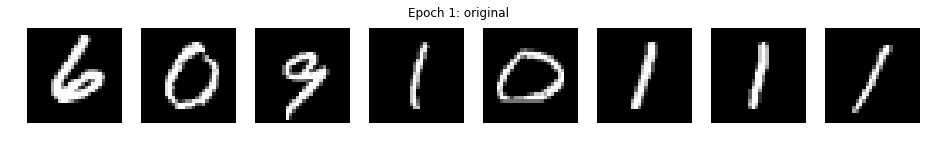

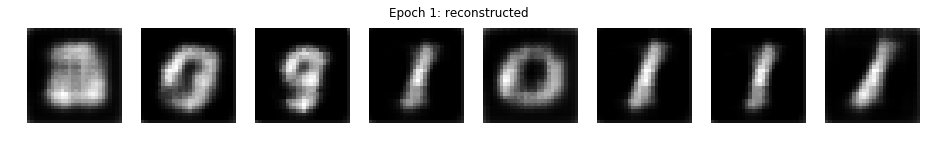

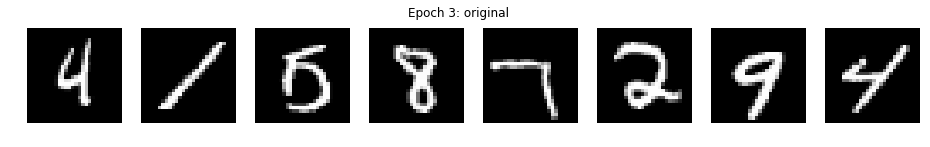

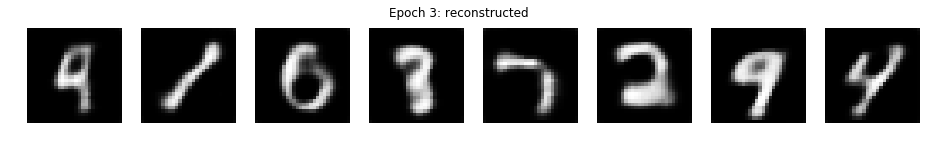

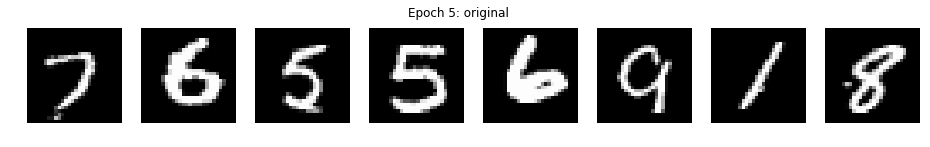

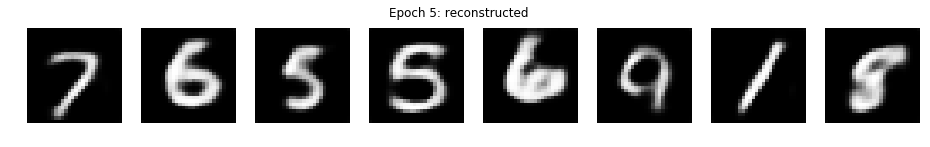

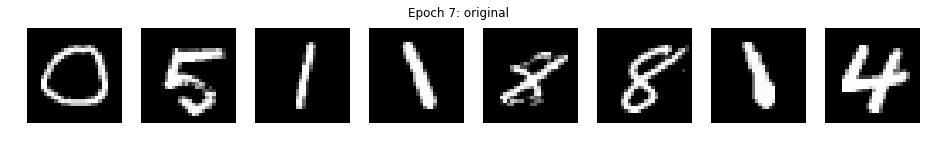

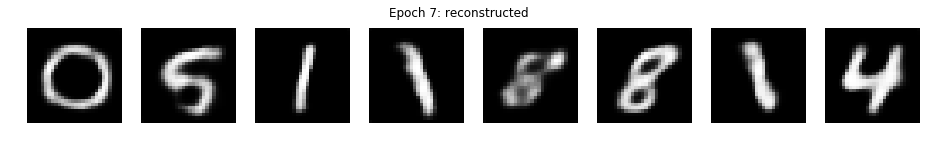

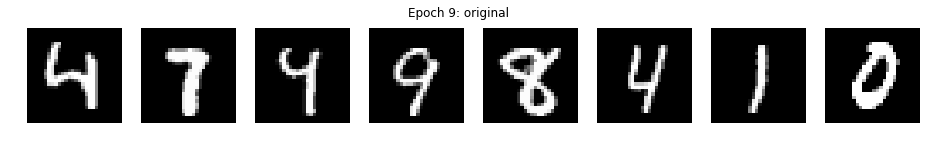

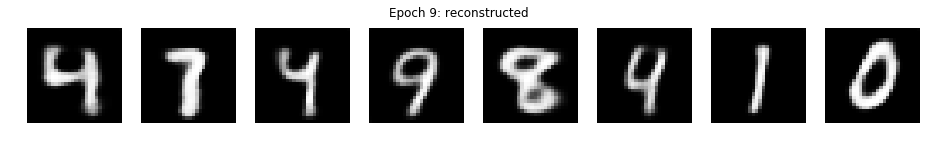

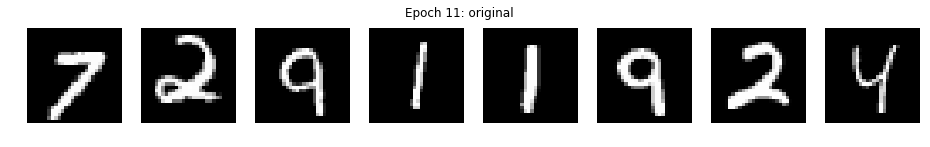

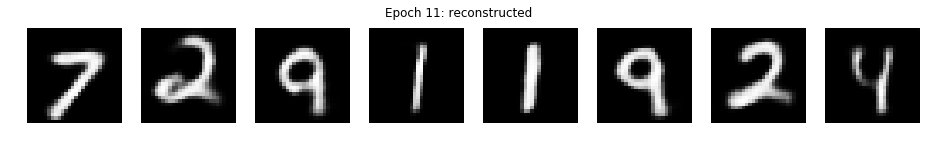

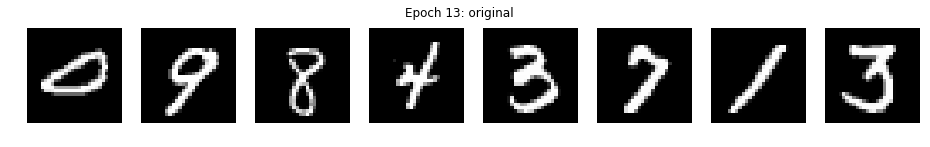

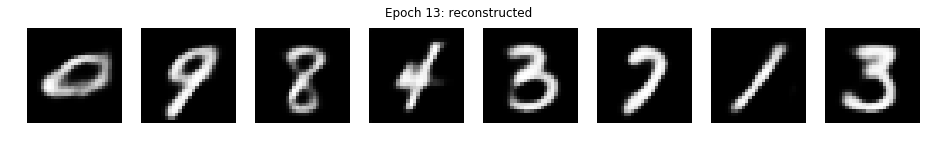

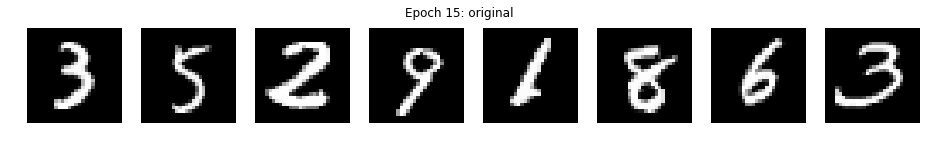

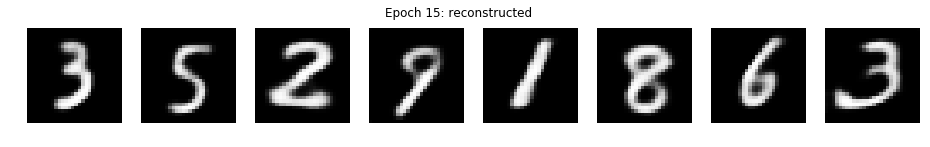

In [8]:
for epoch, (test_images, _) in zip(range(0, num_epochs, 2), test_loader):
  model_t = model_snapshots.get(epoch)
  test_batch = test_images.to(device)
  with th.no_grad():
    reconst_images, _, _ = model_t(test_batch)
  reconst_images = reconst_images.view(-1, 1, 28, 28)
  visualize_images(test_images, title=f'Epoch {epoch+1}: original',
                   rows=1, cols=8)
  visualize_images(reconst_images, title=f'Epoch {epoch+1}: reconstructed',
                   rows=1, cols=8)

### Sampling z ~ N(0, 1)

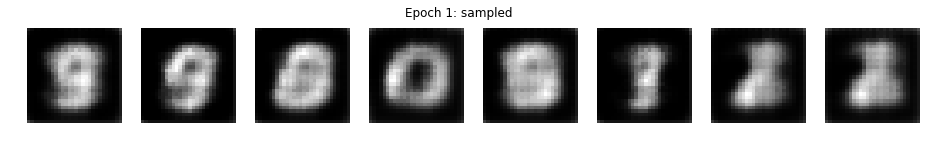

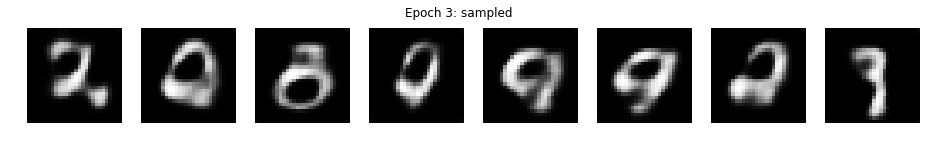

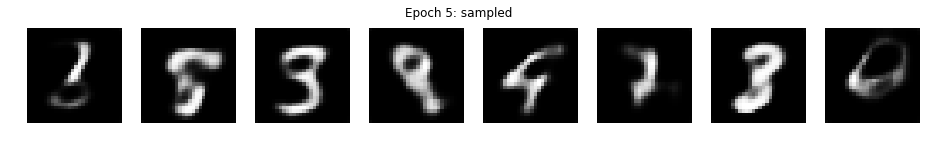

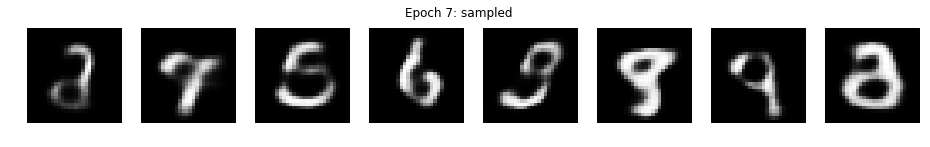

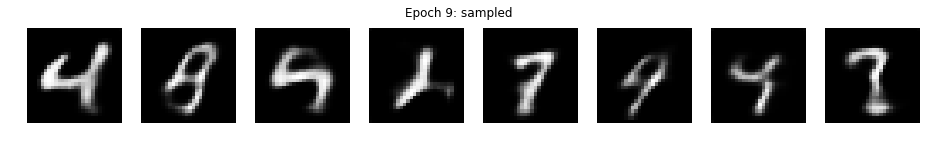

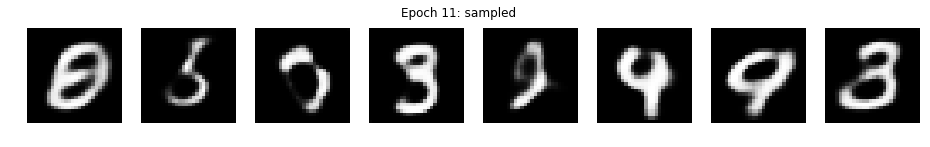

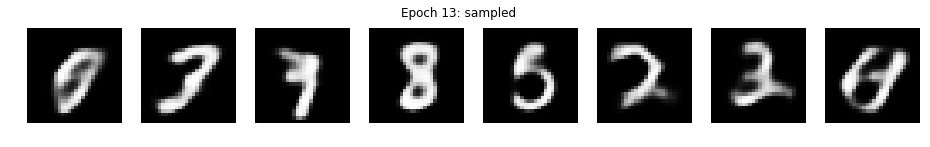

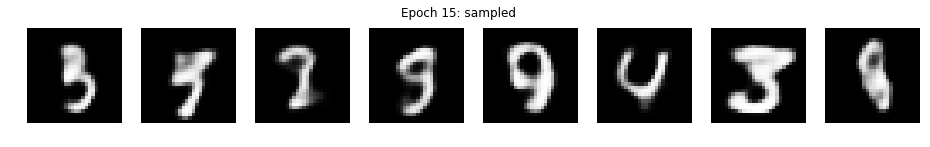

In [9]:
for epoch in range(0, num_epochs, 2):
  model_t = model_snapshots.get(epoch)
  images = sample_images(model_t, num_samples=batch_size)
  visualize_images(images, title=f'Epoch {epoch+1}: sampled', rows=1, cols=8)

## Embedding t-SNE

In [146]:
def embed(model, data_loader):
  embeddings = []
  ys = []
  for x, y in data_loader:
    x = x.to(device)
    mu, logvar = model.encode(x)
    embeddings.append(mu.detach())
    ys.append(y.detach())
  return np.concatenate(embeddings), np.concatenate(ys)

train_embedding, train_y = embed(model, data_loader)
test_embedding, test_y = embed(model, test_loader)
print(train_embedding.shape, test_embedding.shape)

(60000, 20) (10000, 20)


In [0]:
def tsne(data, **kwargs):
  try:
    # https://github.com/DmitryUlyanov/Multicore-TSNE
    # ~50x speedup
    from MulticoreTSNE import MulticoreTSNE as TSNE
    tsne_model = TSNE(n_jobs=8, **kwargs)
  except ImportError:
    print('MulticoreTSNE not found. Falling back to sklearn.')
    from sklearn.manifold import TSNE
    kwargs['n_iter'] = kwargs.get('n_iter', 300)
    tsne_model =TSNE(**kwargs)
  return tsne_model.fit_transform(data)

def plot_tsne(data, labels):
  plt.scatter(data[:, 0], data[:, 1], c=labels,
              s=2, cmap=plt.cm.get_cmap('jet', 10))
  plt.colorbar(ticks=range(10))
  plt.clim(-0.5, 9.5)

### Train (slow with n=60000)

In [65]:
train_tsne = tsne(train_embedding)
train_tsne.shape

(60000, 2)

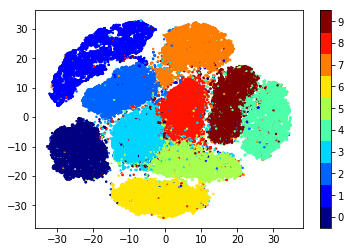

In [66]:
plot_tsne(train_tsne, train_y)

### Test

In [70]:
test_tsne = tsne(test_embedding)
test_tsne.shape

(10000, 2)

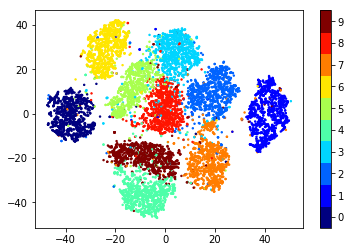

In [71]:
plot_tsne(test_tsne, test_y)

## Embedding arithmetic

In [0]:
import functools

embedding = train_embedding
label = train_y

reduce = functools.partial(np.mean, axis=0, keepdims=True)

def em(label):
  return train_embedding[train_y == label]

def em_r(label):
  return reduce(em(label))

def lerp(z_a, z_b, ts=tuple(np.arange(-0.2, 1.2 + 1e-6, 0.2))):
  zs = np.concatenate([(1 - t) * z_a + t * z_b for t in ts])
  images = model.decode_np(zs).detach()
  visualize_images(images,
                   sub_titles=['%.2f' % t for t in ts],
                   rows=1, cols=len(ts))

def arithmetic(a, b, c, ts=(0.1, 0.2, 0.3)): 
  a_mean, b_mean, c_mean = reduce(a), reduce(b), reduce(c)
  diff = a_mean - b_mean
  
  rs = [c_mean + t * diff for t in ts]
  zs = np.concatenate([a_mean, b_mean, c_mean] + rs + [diff])
  images = model.decode_np(zs).detach()
  
  rs_titles = ['c + %.1f * (a - b)' % t for t in ts]
  visualize_images(images,
                   sub_titles=['a', 'b', 'c'] + rs_titles + ['a - b'],
                   rows=1, cols=4 + len(ts))

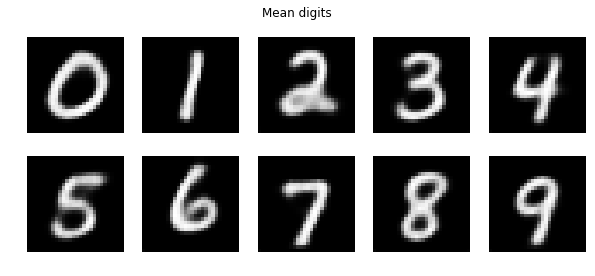

In [165]:
# Plot average of each digit
mean_digits_z = np.concatenate([reduce(em(i)) for i in range(10)])
mean_digits = model.decode_np(mean_digits_z).detach()
visualize_images(mean_digits, title='Mean digits', rows=2, cols=5)

### a - b + c = ?

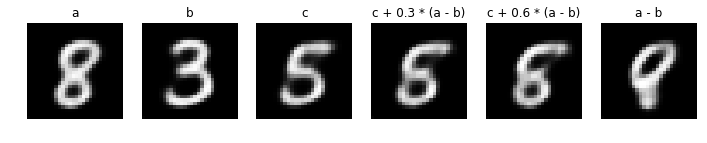

In [367]:
# 8 - 3 rounds out the left side of the digit.
arithmetic(em(8), em(3), em(5), ts=(0.3, 0.6))

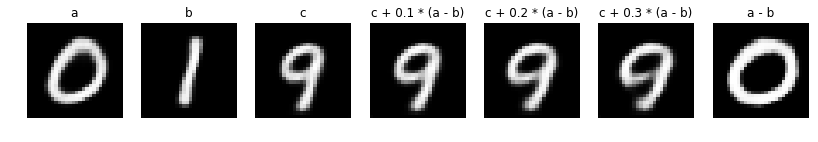

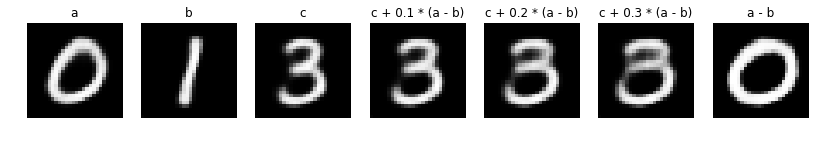

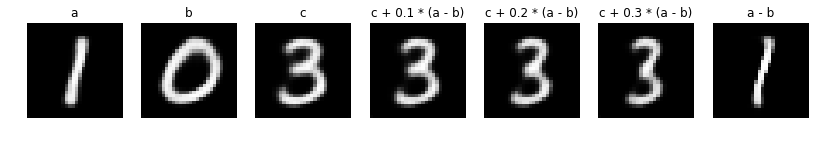

In [374]:
# 0 - 1 makes digits fatter.
arithmetic(em(0), em(1), em(9))
arithmetic(em(0), em(1), em(3))
arithmetic(em(1), em(0), em(3))

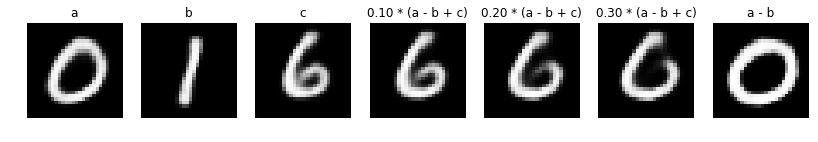

In [350]:
# 0 - 1 also makes digits rounder
arithmetic(em(0), em(1), em(6))

### Interpolation

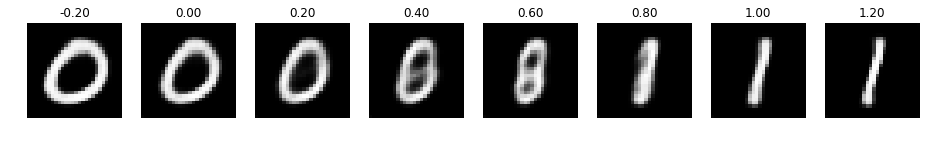

In [338]:
lerp(em_r(0), em_r(1))

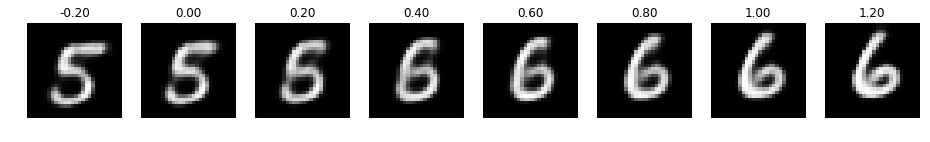

In [336]:
lerp(em_r(5), em_r(6))

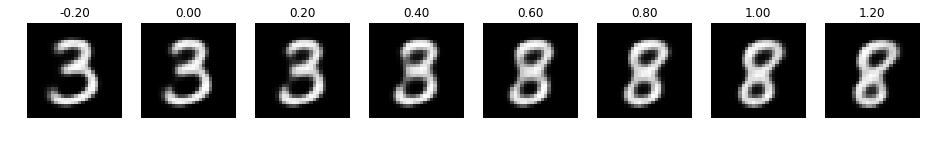

In [337]:
lerp(em_r(3), em_r(8))

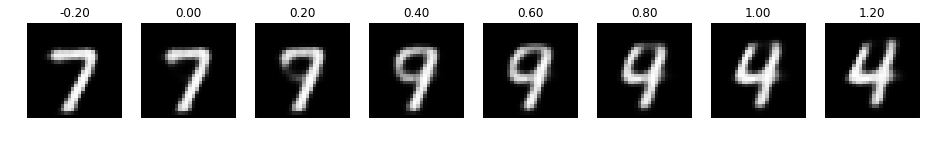

In [339]:
lerp(em_r(7), em_r(4))

## Save model

In [0]:
th.save(model.state_dict(), '/tmp/vae.ckpt')